In [171]:
import csv

import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 各パス指定

In [172]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'

# 分類数設定

In [173]:
NUM_CLASSES = 5

# 学習データ読み込み

In [174]:
X_dataset = np.loadtxt(
    dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [175]:
y_dataset = np.loadtxt(
    dataset, delimiter=',', dtype='int32', usecols=(0))

In [176]:
X_train, X_test, y_train, y_test = train_test_split(
    X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [177]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [178]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_16 (Dropout)            │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 20)             │           860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 5)              │            55 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,125 (4.39 KB)

 Trainable params: 1,125 (4.39 KB)

 Non-trainable params: 0 (0.00 B)

In [179]:
# Callback de ponto de verificação do modelo
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback para interrupção antecipada
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [180]:
# Compilação do modelo
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [181]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 1/31 ━━━━━━━━━━━━━━━━━━━━ 24s 820ms/step - accuracy: 0.2031 - loss: 1.9907
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2573 - loss: 1.8143 - val_accuracy: 0.3596 - val_loss: 1.5483
Epoch 2/1000
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2656 - loss: 1.6546
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2963 - loss: 1.6159 - val_accuracy: 0.3978 - val_loss: 1.4987
Epoch 3/1000
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3281 - loss: 1.5465
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3311 - loss: 1.5450 - val_accuracy: 0.4282 - val_loss: 1.4612
Epoch 4/1000
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2812 - loss: 1.5469
Epoch 4: saving model to model/keypoint_classifier/keypoint_classifier.ker

In [182]:
# モデル評価
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9788 - loss: 0.2182 


In [183]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [184]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
[0.06538744 0.4175838  0.51566136 0.00074432 0.00062304]
2


# 混同行列

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step


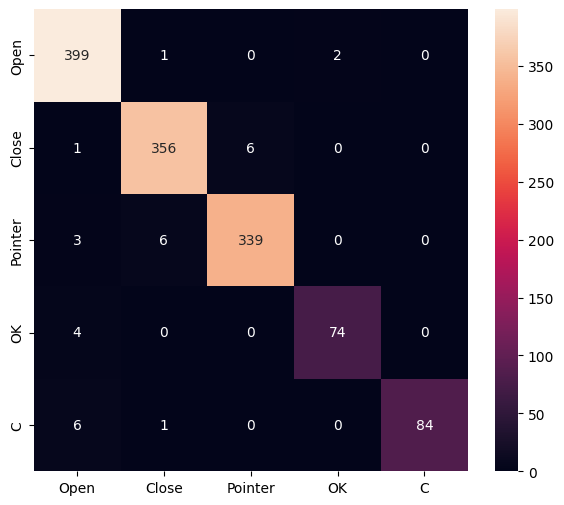

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       402
           1       0.98      0.98      0.98       363
           2       0.98      0.97      0.98       348
           3       0.97      0.95      0.96        78
           4       1.00      0.92      0.96        91

    accuracy                           0.98      1282
   macro avg       0.98      0.96      0.97      1282
weighted avg       0.98      0.98      0.98      1282



In [186]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    with open('model/keypoint_classifier/keypoint_classifier_label.csv',
            encoding='utf-8-sig') as f:
        keypoint_classifier_labels = csv.reader(f)
        keypoint_classifier_labels = [
            row[0] for row in keypoint_classifier_labels
        ]
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    labels = [keypoint_classifier_labels[i] for i in sorted(list(set(y_true)))]
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [ ]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)

# mobilenet_save_path = os.path.join('model/keypoint_classifier/', "mobilenet/1/")
# tf.saved_model.save(model, mobilenet_save_path)

In [ ]:
# モデルを変換(量子化)
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_saved_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

TypeError: Expected binary or unicode string, got <Sequential name=sequential_7, built=True>

# 推論テスト

In [ ]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [ ]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [ ]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 24 ms


In [ ]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[9.8124069e-01 1.5046170e-02 3.7110685e-03 2.0492430e-06]
0
